In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import sys
sys.path.append('../src/')

import unet
from unet import utils
from unet.datasets import circles

In [2]:
train_dataset, validation_dataset = circles.load_data(100, nx=256, ny=256, splits=(0.8, 0.2))

In [3]:
from tensorflow.python import ipu

cfg = ipu.config.IPUConfig()
cfg.auto_select_ipus = 2
cfg.configure_ipu_system()

In [4]:
with ipu.ipu_strategy.IPUStrategy(enable_dataset_iterators=False).scope():
    unet_model = unet.build_model(channels=circles.channels,
                                  num_classes=circles.classes,
                                  layer_depth=3,
                                  filters_root=16)
    unet.finalize_model(unet_model)
    
    # === Model-parallel: pipeline the graph across 2 IPUs ===
    # Get the individual assignments - note that they are returned in post-order.
    assignments = unet_model.get_pipeline_stage_assignment()
    # Iterate over them and set their pipeline stages.
    stage_id = 0
    for assignment in assignments:
        assignment.pipeline_stage = stage_id
        # Split the model on the `conv4_block2_add` layer.
        if assignment.layer.name.startswith("upconv_block"):
            stage_id = 1
    # Set the assignments to the model.
    unet_model.set_pipeline_stage_assignment(assignments)
    unet_model.print_pipeline_stage_assignment_summary()
    unet_model.set_pipelining_options(gradient_accumulation_steps_per_replica=4)
    
    trainer = unet.Trainer(checkpoint_callback=False)    
    trainer.fit(unet_model,
                train_dataset,
                validation_dataset,
                epochs=5,
                batch_size=1)
    
    prediction = unet_model.predict(validation_dataset.batch(batch_size=1, drop_remainder=True))    

Model: "unet"
_________________________________________________________________________________________
Layer (type) (node index)          Input Layers                        Pipeline Stage    
conv_block (ConvBlock) (0)         inputs                              0                 
_________________________________________________________________________________________
max_pooling2d (MaxPooling2D) (0)   conv_block                          0                 
_________________________________________________________________________________________
conv_block_1 (ConvBlock) (0)       max_pooling2d                       0                 
_________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D) (0) conv_block_1                        0                 
_________________________________________________________________________________________
conv_block_2 (ConvBlock) (0)       max_pooling2d_1                     0              

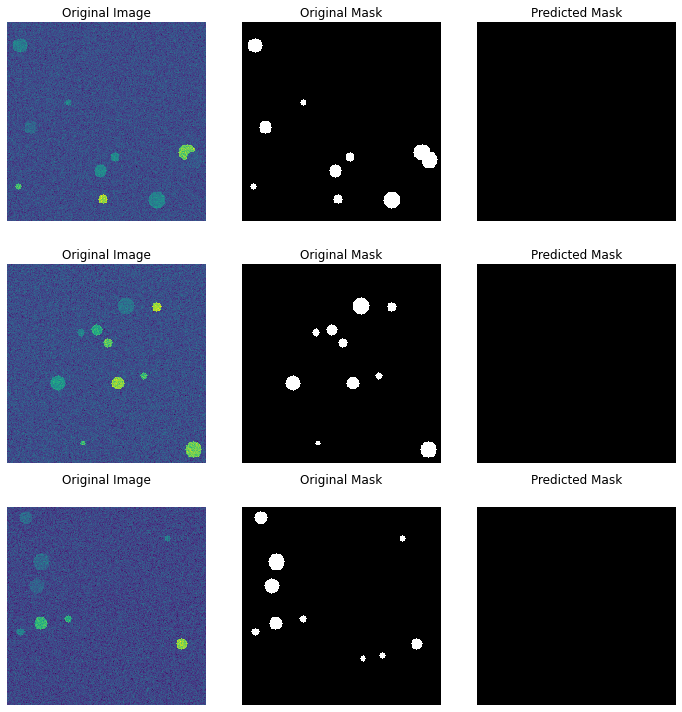

In [5]:
fig, ax = plt.subplots(3, 3, sharex=True, sharey=True, figsize=(10,10))
dataset = validation_dataset.map(utils.crop_image_and_label_to_shape(prediction.shape[1:]))

for i, (image, label) in enumerate(dataset.take(3)):
    ax[i][0].matshow(image[..., -1]); ax[i][0].set_title('Original Image'); ax[i][0].axis('off')
    ax[i][1].matshow(np.argmax(label, axis=-1), cmap=plt.cm.gray); ax[i][1].set_title('Original Mask'); ax[i][1].axis('off')
    ax[i][2].matshow(np.argmax(prediction[i,...], axis=-1), cmap=plt.cm.gray); ax[i][2].set_title('Predicted Mask'); ax[i][2].axis('off')
plt.tight_layout()